### Importing the dependencies

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#the top 7 S&P 500 companies
Top_6 = {
"Apple" :"AAPL",
"Microsoft": "MSFT",
"Alphabet(Google)" : "GOOGL",
"Amazon": "AMZN",
"NVIDIA":"NVDA",
"Meta Platforms(facebook)":"FB"
}

In [3]:
names = [i for i in Top_6.values()]
names

['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'FB']

### Importing Data Using pandas

In [4]:
data = pd.read_csv('all_stocks_5yr.csv')
data.sample(10)

,date,open,high,low,close,volume,Name
22474,2017-05-11,74.12,74.23,73.6703,73.96,1323921,AFL
390062,2017-07-26,12.52,12.62,12.1500,12.18,14425313,MRO
514265,2017-02-06,48.97,49.09,48.7200,48.76,3145729,SO
211581,2015-03-13,32.60,32.60,31.8500,32.39,6460437,EXC
547709,2016-05-23,93.91,94.41,93.1800,93.25,465040,TSCO
353048,2015-07-28,23.50,23.88,23.3800,23.74,1239728,LUK
248999,2017-11-27,31.78,32.08,31.7000,32.05,6402655,GLW
218926,2014-05-14,59.53,60.45,58.9500,59.23,47428583,FB
530220,2016-12-06,24.27,24.36,23.9550,24.20,11043220,SYMC
63249,2014-11-21,157.64,158.16,157.0100,157.43,849627,AVB


In [199]:
len(data) * 5


3095200

In [196]:
#the stock prices of the top 6 S&P 500 comapnies
data_feed = data.loc[data['Name'].isin(names)]
data_feed.sample(5)

,date,open,high,low,close,volume,Name
2435,2017-10-10,156.055,158.00,155.100,155.900,15617014,AAPL
47115,2015-12-30,691.890,695.49,686.375,689.070,3519003,AMZN
422668,2013-04-02,12.420,12.45,12.200,12.275,9288074,NVDA
251120,2016-05-02,711.920,715.41,706.360,714.410,1673820,GOOGL
251380,2017-05-12,957.850,957.98,952.060,955.140,1214851,GOOGL


In [200]:
len(data_feed) * 5


37770

In [6]:
data_feed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7554 entries, 1259 to 423891
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    7554 non-null   object 
 1   open    7554 non-null   float64
 2   high    7554 non-null   float64
 3   low     7554 non-null   float64
 4   close   7554 non-null   float64
 5   volume  7554 non-null   int64  
 6   Name    7554 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 472.1+ KB


In [197]:
#converitng the date and time column to "datetime" type
data_feed['date'] = pd.to_datetime(data_feed['date'])

In [8]:
data_feed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7554 entries, 1259 to 423891
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7554 non-null   datetime64[ns]
 1   open    7554 non-null   float64       
 2   high    7554 non-null   float64       
 3   low     7554 non-null   float64       
 4   close   7554 non-null   float64       
 5   volume  7554 non-null   int64         
 6   Name    7554 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 472.1+ KB


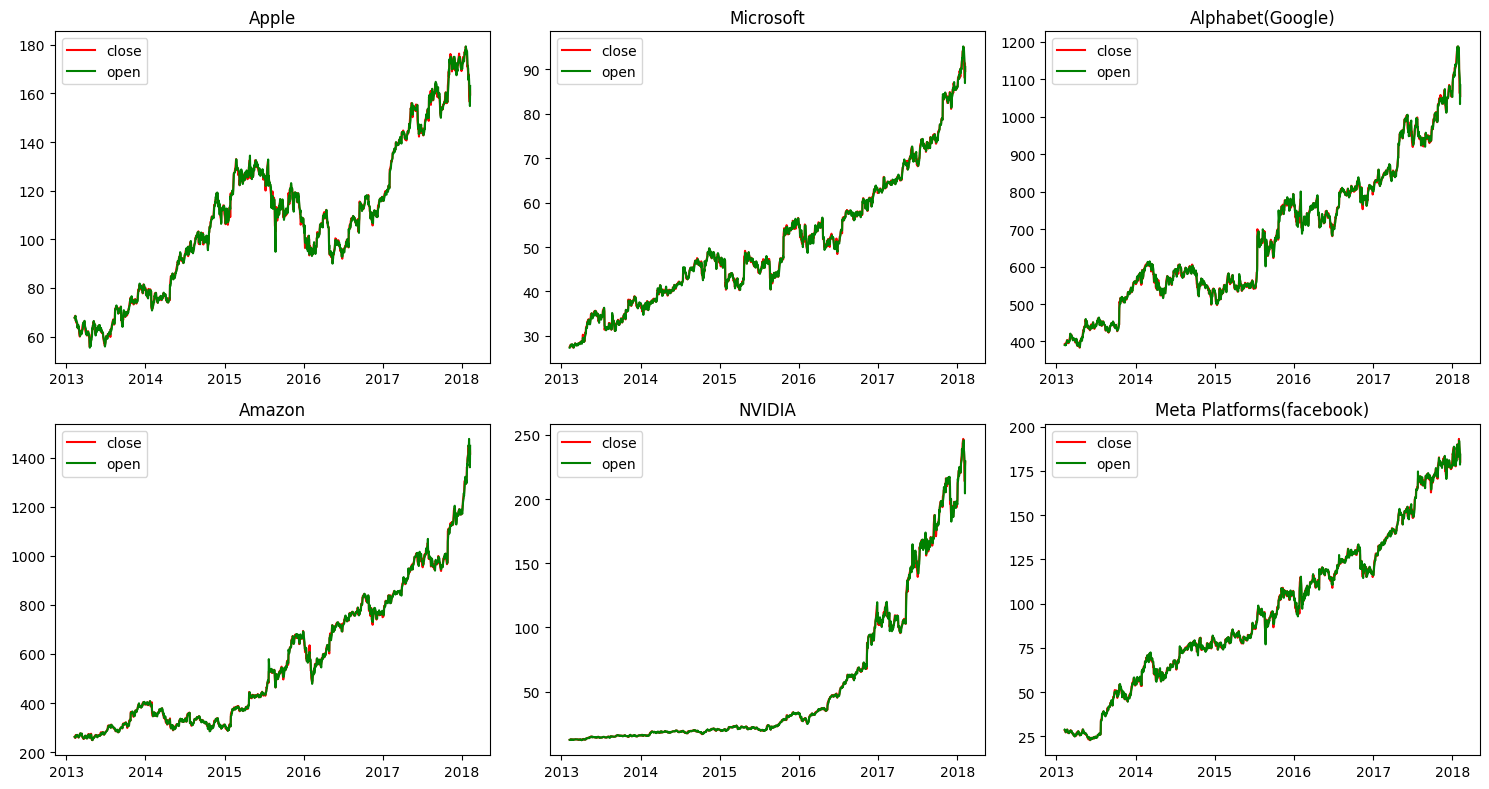

In [9]:
#observing the opening and closing of the top 6 companies listed on S&P 500
plt.figure(figsize= (15,8))
index = 1
for key,value in Top_6.items():
    plt.subplot(2,3,index)
    c = data_feed[data_feed['Name'] == value]
    plt.plot(c['date'], c['close'], c="r", label="close") 
    plt.plot(c['date'], c['open'], c="g", label="open") 
    plt.title(key) 
    plt.legend() 
    plt.tight_layout()
    index += 1

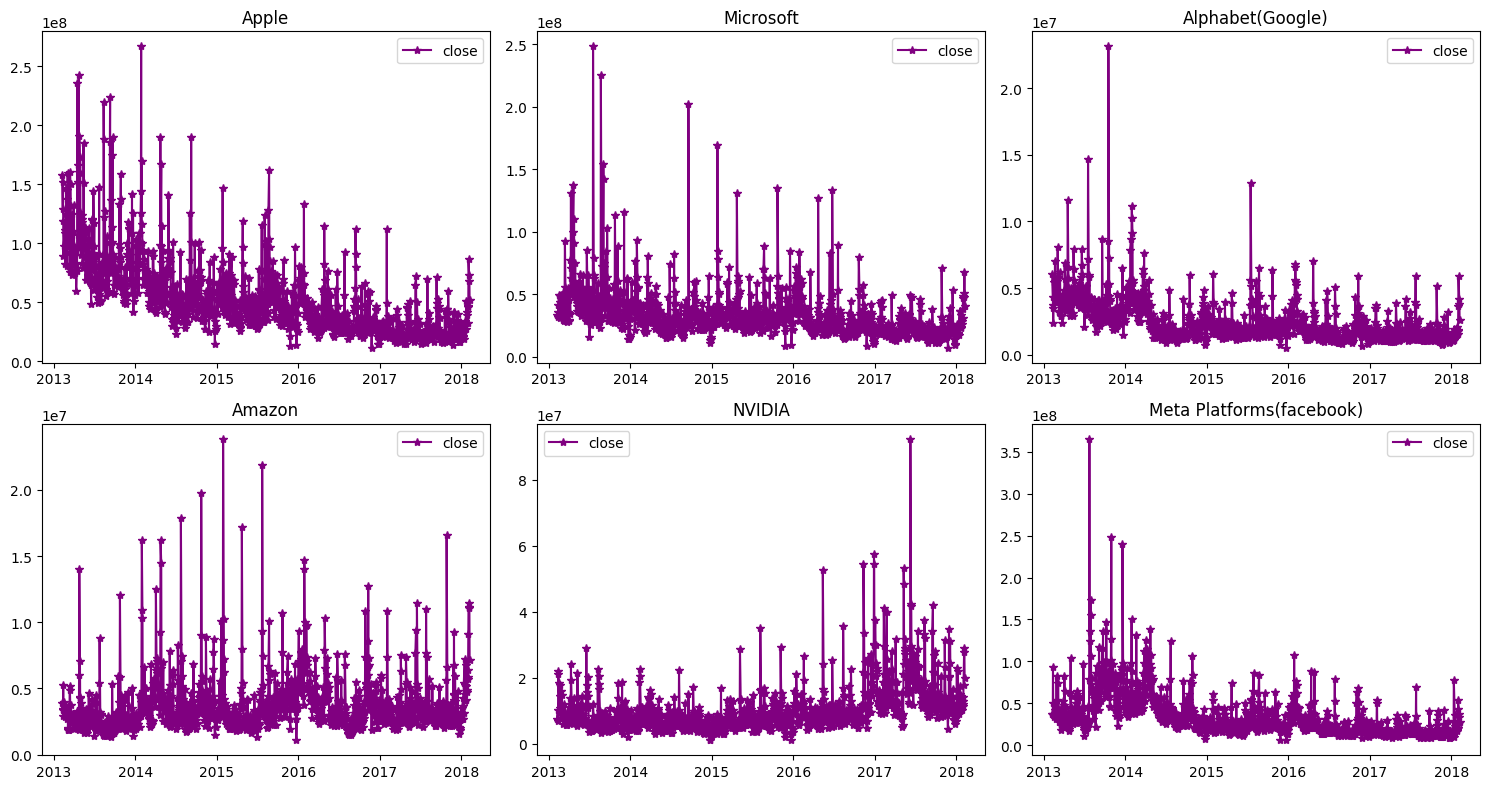

In [128]:
#observinf their respective volumes
plt.figure(figsize= (15,8))
index = 1
for key,value in Top_6.items():
    plt.subplot(2,3,index)
    c = data_feed[data_feed['Name'] == value]
    plt.plot(c['date'], c['volume'], c="purple", label="close",marker= "*") 
    plt.title(key) 
    plt.legend() 
    plt.tight_layout()
    index += 1

### Pre-processing the data

In [80]:
#get the data of the resspective company
def get_company_data(name):
    company_data = data[data['Name'] == name] 
    company_data['date'] = pd.to_datetime(company_data['date'])
    return company_data

#analyse the comapny's stock prices individually
def show_company_profile(company_data):
    prediction_range = company_data.loc[(company_data['date'] > datetime(2013, 1, 1)) & (company_data['date'] < datetime(2018, 1, 1))] 
    plt.plot(company_data['date'],company_data['close']) 
    plt.xlabel("date") 
    plt.ylabel("close") 
    plt.title("Stock Prices") 
    plt.show()


In [95]:
company_names = list(Top_6.keys())

In [105]:
#separate the training data from whole data
def get_training_data(company_data):    
    #extract the closing values 
    close_data = company_data.filter(['close']) 
    dataset = close_data.values 
    training = int(np.ceil(len(dataset) * .95))     
    return dataset , training

#scale the data from 0 to 1 so as to reduce bias
def get_scaled_data(dataset):  
    #scale the closing values
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_data = scaler.fit_transform(dataset) 
    return scaler,scaled_data

#extract x_train and y_train from the training data
def get_x_and_y(training , scaled_data):    
    #get the training data    
    train_data = scaled_data[0:int(training), :] 
    # prepare feature and labels 
    x_train = [] 
    y_train = [] 

    time_step = 60
    for i in range(time_step, len(train_data)): 
        x_train.append(train_data[i-time_step:i, 0]) 
        y_train.append(train_data[i, 0]) 
    
    x_train, y_train = np.array(x_train), np.array(y_train) 
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
    
    return x_train , y_train
        

### Developing and compiling the model

In [88]:
def LSTM_model(x_train):
    model = Sequential(
        [
            layers.Input(shape= (x_train.shape[1], 1)),
            layers.LSTM(128 , return_sequences= True),
            layers.LSTM(128 , return_sequences= False),
            layers.Dense(64),
            layers.Dropout(0.2),
            layers.Dense(1)
        ]
    )
    model.compile(optimizer='adam' , loss= 'mean_squared_error')
    return model

### Training the model

In [89]:
def fit_model(model , x_train , y_train):
    history = model.fit(x_train,y_train,batch_size=64,epochs=10)
    return history

### Extracting the test data and Predicting

In [122]:
def get_test_data(training,dataset,scaled_data):
    test_data = scaled_data[training - 60:, :] 
    x_test = [] 
    y_test = dataset[training:, :] 
    for i in range(60, len(test_data)): 
        x_test.append(test_data[i-60:i, 0]) 
        
    x_test = np.array(x_test) 
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
    return x_test,y_test

def predict_value(x_test,model,scaler):
    predictions = model.predict(x_test) 
    predictions = scaler.inverse_transform(predictions) 
    return predictions
  
def evaluation_metrics(y_test , predictions):
    mse = np.mean(((predictions - y_test) ** 2)) 
    return mse,np.sqrt(mse)

### Analyzing the results

In [163]:
def show_result(company_data,training,predictions):
    train = company_data[:training] 
    test = company_data[training:] 
    test['Predictions'] = predictions 
    
    # plt.figure(figsize=(10, 8)) 
    plt.plot(train['date'], train['close']) 
    plt.plot(test['date'], test[['close', 'Predictions']]) 
    plt.title('Apple Stock Close Price') 
    plt.xlabel('Date') 
    plt.ylabel("Close") 
    plt.legend(['Train', 'Test', 'Predictions']) 

In [96]:
names

['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'FB']

In [97]:
Top_6

{'Apple': 'AAPL',
 'Microsoft': 'MSFT',
 'Alphabet(Google)': 'GOOGL',
 'Amazon': 'AMZN',
 'NVIDIA': 'NVDA',
 'Meta Platforms(facebook)': 'FB'}

### PREDICTING VALUES FOR ALL THE COMPANIES


In [171]:
def get_company_predcitions(name):
    company_data = get_company_data(name)
    
    #the data that is to be used for training
    dataset , training = get_training_data(company_data)
    
    #scaling the data
    scaler , scaled_data = get_scaled_data(dataset)
    
    #extracting x_train and y_train from the scaled data
    x_train , y_train = get_x_and_y(training , scaled_data)
    
    #developing the model
    model = LSTM_model(x_train)    
    
    #training the model
    history = fit_model(model , x_train, y_train)
    
    #getting x_test and y_test
    x_test,y_test = get_test_data(training,dataset,scaled_data) 
    
    #predciting values
    predictions = predict_value(x_test,model,scaler)
    
    #evaluating the model
    MSE , RMSE = evaluation_metrics(y_test,predictions)
    
    return predictions,np.array([MSE , RMSE])
    

In [172]:
final_predictions = []
error_values = []
for name in names:
    prediction , evaluation = get_company_predcitions(name)
    final_predictions.append(prediction)
    error_values.append(evaluation)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0697
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0043
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0026
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0021
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0019
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0024
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0018
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0017
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0018
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0360
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0022
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0015
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0013
Epoch 5/10
18/18 ━━━━━━━━━━━

In [173]:
final_predictions = np.array(final_predictions)
error_values = np.array(error_values)

In [174]:
final_predictions.shape,error_values.shape

((6, 62, 1), (6, 2))

In [175]:
companies_data = []
for name in names:
    c = get_company_data(name)
    companies_data.append(c)    

In [176]:
training_final = 1197

In [180]:
company_names

['Apple',
 'Microsoft',
 'Alphabet(Google)',
 'Amazon',
 'NVIDIA',
 'Meta Platforms(facebook)']

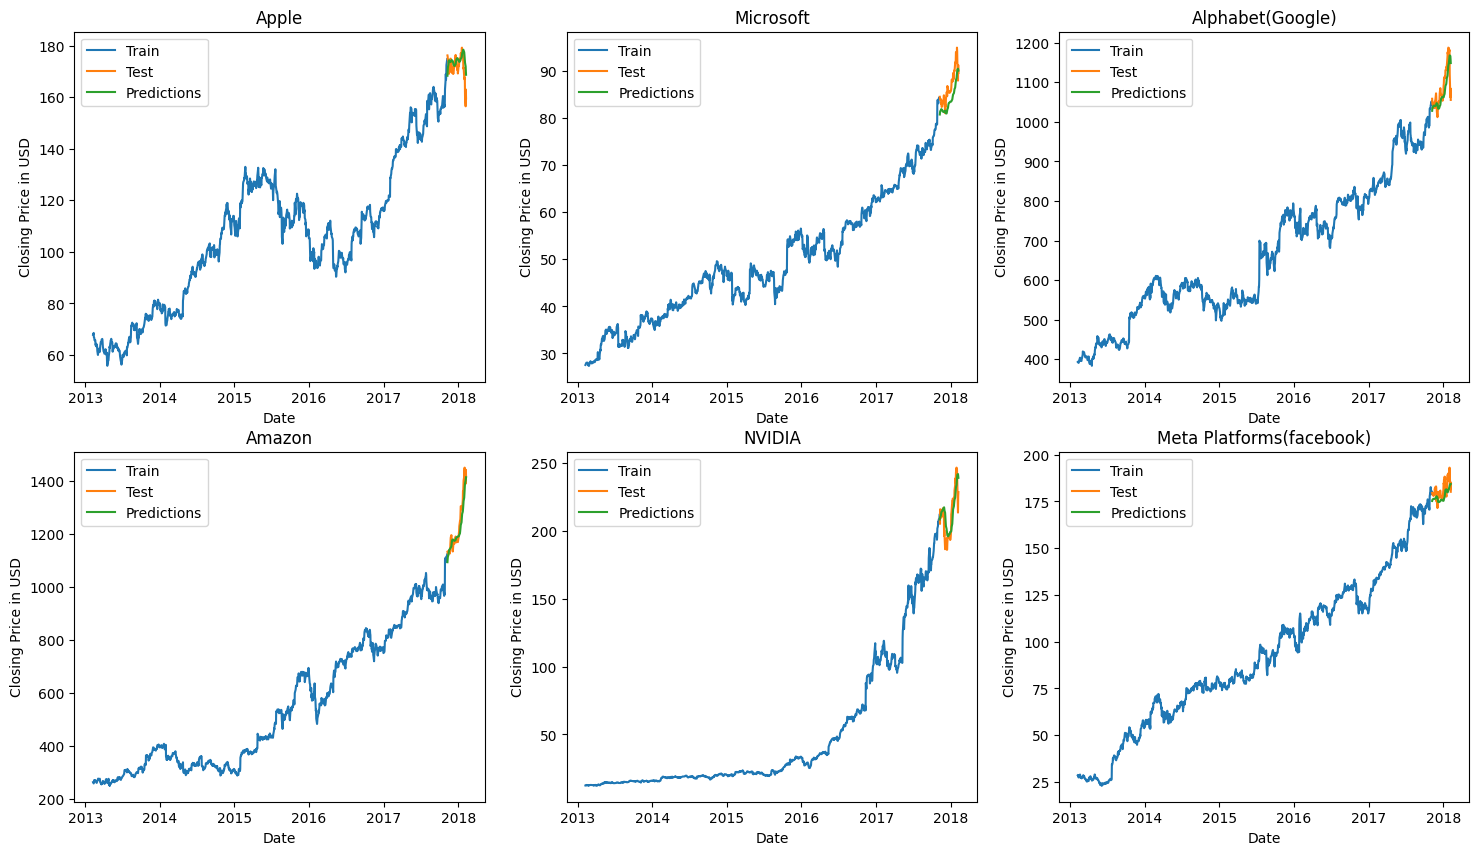

In [194]:
plt.figure(figsize= (18,10))
index = 1
for i in range(6):
    train = companies_data[i][:training] 
    test = companies_data[i][training:] 
    test['Predictions'] = final_predictions[i] 
    
    plt.subplot(2,3,index)
    plt.plot(train['date'], train['close']) 
    plt.plot(test['date'], test[['close', 'Predictions']]) 
    plt.title(company_names[i]) 
    plt.xlabel('Date') 
    plt.ylabel("Closing Price in USD") 
    plt.legend(['Train', 'Test', 'Predictions']) 
    index += 1

#### Analying the errors

In [195]:
errors = pd.DataFrame(error_values,columns= ['MSE' , 'RMSE'])
errors.insert(0, 'Names', company_names)
errors

,Names,MSE,RMSE
0,Apple,22.678327,4.762177
1,Microsoft,10.835423,3.291720
2,Alphabet(Google),1099.542505,33.159350
3,Amazon,1276.756232,35.731726
4,NVIDIA,111.485439,10.558667
5,Meta Platforms(facebook),26.758313,5.172844
